In [41]:
import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
from matplotlib import pyplot as plt

In [42]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 12
ALT_MIN, ALT_MAX = 0.5, 64.5
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

CHUNK_SIZE_L = 50000
CHUNK_SIZE_S = 25000

In [43]:
def process_dataarray(da_o3):
    if da_o3.name != 'O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR':
        da_transposed = da_o3.transpose('time', 'altitude')
        
        n_time = da_transposed.sizes['time']
        n_alt = da_transposed.sizes['altitude']
        
        time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
        alt_chunks = min(32, n_alt)
        
        if isinstance(da_transposed.data, da.Array):
            da_transposed = da_transposed.chunk({'time': time_chunks, 'altitude': alt_chunks})
        else:
            da_transposed.data = da.from_array(da_transposed.data,
                                            chunks=(time_chunks, alt_chunks))
        return da_transposed
    else:
        n_time = da_o3.sizes['DATETIME']
        n_alt = da_o3.sizes['altitude1']

        time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
        alt_chunks = min(32, n_alt)
        
        if isinstance(da_o3.data, da.Array):
            da_o3 = da_o3.chunk({'DATETIME': time_chunks, 'altitude1': alt_chunks})
        else:
            da_o3.data = da.from_array(da_o3.data,
                                            chunks=(time_chunks, alt_chunks))
        return da_o3

def compute_diffs(o3L, o3S):
    """Vectorized relative, absolute difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [44]:
import OSIRIS.OSIRIS_helper as OSIRIS
import PEARL_FTIR.PEARL_FTIR_helper as PEARL

In [45]:
daO = OSIRIS.get_vmr()
daP = PEARL.get_vmr()

In [46]:
daO = daO.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})
daP = daP.sel(altitude1=slice(ALT_MIN, ALT_MAX)).interp({"altitude1": ALT_GRID})

daO = process_dataarray(daO)
daP = process_dataarray(daP)

In [47]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)

In [48]:
o3O_arr = daO.values.astype(np.float32)
latO = daO.latitude.values
lonO = daO.longitude.values
tO = daO.time.values.astype('datetime64[ns]')

o3P_arr = daP.values.astype(np.float32)
tP = daP.DATETIME.values.astype('datetime64[ns]')
num_P_data = len(tP)
latP = np.array([PEARL.latitude] * num_P_data)
lonP = np.array([PEARL.longitude] * num_P_data)

tP_min = tP.min() - TIME_TOL
tP_max = tP.max() + TIME_TOL
time_mask = (tO >= tP_min) & (tO <= tP_max)
tO_filtered = tO[time_mask]
o3O_arr_filtered = o3O_arr[time_mask]
latO_filtered = latO[time_mask]
lonO_filtered = lonO[time_mask]

client.close()
cluster.close()
del o3O_arr, latO, lonO
gc.collect()

60946

In [49]:
tO_ns = tO_filtered.astype(np.int64)
tP_ns = tP.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)

n_alt = len(ALT_GRID)
MAX_DIST_RAD = MAX_DIST_KM / EARTH_RADIUS_KM

processed_pairs = 0
o3P_coincidences = []
o3O_coincidences = []
measurement_times = []

time_bins = np.arange(tO_ns.min(), tO_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tO_ns, time_bins)

max_bin = len(time_bins) + 1
time_binned_arrays = [np.array([], dtype=np.int64) for _ in range(max_bin + 1)]

for bin_id in range(0, max_bin + 1):
    time_binned_arrays[bin_id] = np.where(bin_indices == bin_id)[0]

bin_offsets = np.arange(-1, 2)

for s_idx, (s_time, s_lat, s_lon) in enumerate(zip(tP_ns, latP, lonP)):
    if s_idx % 10000 == 0:
        print(f"Processing ACE-FTS point {s_idx}/{len(tP)}...")
    
    center_bin = np.digitize(s_time, time_bins)
    bin_ids = center_bin + bin_offsets
    bin_ids = bin_ids[(bin_ids >= 1) & (bin_ids < max_bin)]

    candidate_indices = np.concatenate([time_binned_arrays[bin_id] for bin_id in bin_ids])
    if candidate_indices.size == 0:
        continue

    time_diffs = np.abs(tO_ns[candidate_indices] - s_time)
    time_mask = time_diffs <= TIME_TOL_ns

    if not np.any(time_mask):
        continue

    time_valid_indices = candidate_indices[time_mask]
    candidate_lats = latO_filtered[time_valid_indices]
    candidate_lons = lonO_filtered[time_valid_indices]
    
    dists = haversine_vectorized(s_lat, s_lon, candidate_lats, candidate_lons)
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]

    if min_dist <= MAX_DIST_KM:
        best_L_idx = time_valid_indices[min_idx]
        o3O_coincidences.append(o3O_arr_filtered[best_L_idx])
        o3P_coincidences.append(o3P_arr[s_idx])
        processed_pairs += 1
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at ACE point {s_idx}...")

        measurement_times.append(tO_ns[best_L_idx])

o3P_coincidences = np.vstack(o3P_coincidences)
o3O_coincidences = np.vstack(o3O_coincidences)
print(f"Total coincidences found: {processed_pairs}")

Processing ACE-FTS point 0/6261...
Found 1000 pairs at ACE point 1325...
Found 2000 pairs at ACE point 2928...
Found 3000 pairs at ACE point 4474...
Total coincidences found: 3706


In [50]:
import matplotlib as mpl
max_time = max(measurement_times)
min_time = min(measurement_times)
n_coincidences = len(measurement_times)
normalizer = plt.Normalize(vmin=min_time, vmax=max_time, clip=True)
cmap = plt.get_cmap('nipy_spectral', n_coincidences)
measurement_colors = cmap(np.linspace(0, 1, n_coincidences))
mappable = mpl.cm.ScalarMappable(norm=normalizer, cmap=cmap)


C:\Users\salla\AppData\Local\Temp\ipykernel_14156\1475746097.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.get_ticks().astype('datetime64[ns]').astype('datetime64[D]').astype(str))


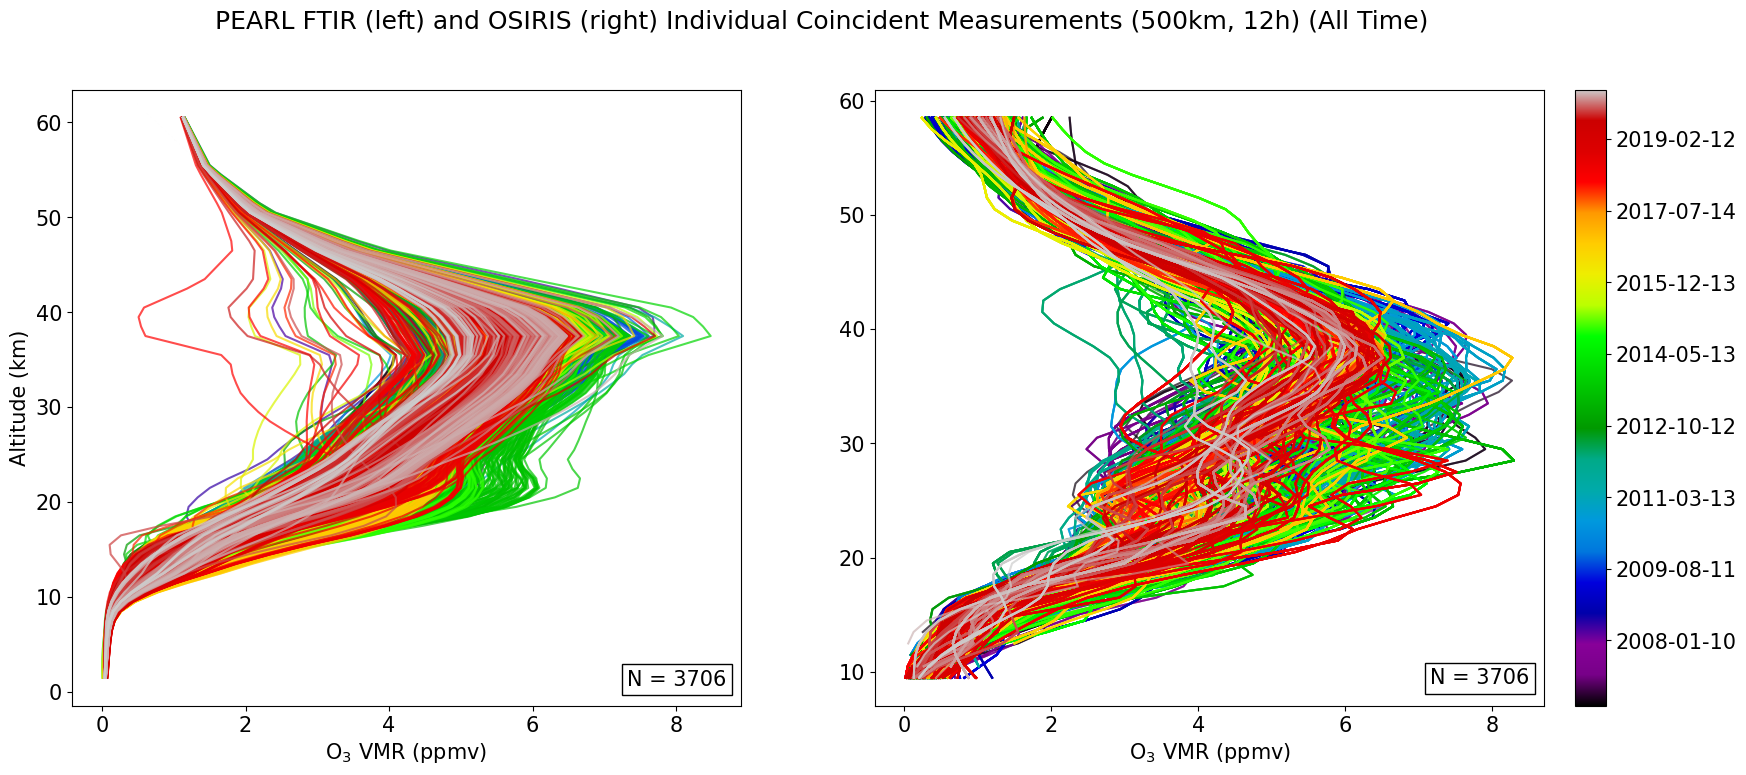

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

n_coincidences = o3P_coincidences.shape[0]

cmap = plt.get_cmap('nipy_spectral', n_coincidences)
measurement_colors = cmap(np.linspace(0, 1, n_coincidences))

for coincidence_idx in range(n_coincidences):
    pearl_ftir_values = o3P_coincidences[coincidence_idx, :] * 10**6
    
    osiris_values = o3O_coincidences[coincidence_idx, :] * 10**6
    
    axes[0].plot(
        pearl_ftir_values,
        ALT_GRID,
        color=measurement_colors[coincidence_idx],
        alpha=0.7
    )
    
    axes[1].plot(
        osiris_values,
        ALT_GRID,
        color=measurement_colors[coincidence_idx],
        alpha=0.7
    )

axes[0].set_xlabel("O$_3$ VMR (ppmv)")
axes[1].set_xlabel("O$_3$ VMR (ppmv)")
axes[0].set_ylabel("Altitude (km)")


cbar = fig.colorbar(
    mappable,
    ax=axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.02
)

cbar.ax.set_yticklabels(cbar.get_ticks().astype('datetime64[ns]').astype('datetime64[D]').astype(str))

plt.suptitle("PEARL FTIR (left) and OSIRIS (right) Individual Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)")

axes[0].text(0.830, 0.0325, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes[0].transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
axes[1].text(0.830, 0.035, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes[1].transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [52]:
rel, abs = compute_diffs(o3O_coincidences, o3P_coincidences)

C:\Users\salla\AppData\Local\Temp\ipykernel_14156\1842317745.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.get_ticks().astype('datetime64[ns]').astype('datetime64[D]').astype(str))


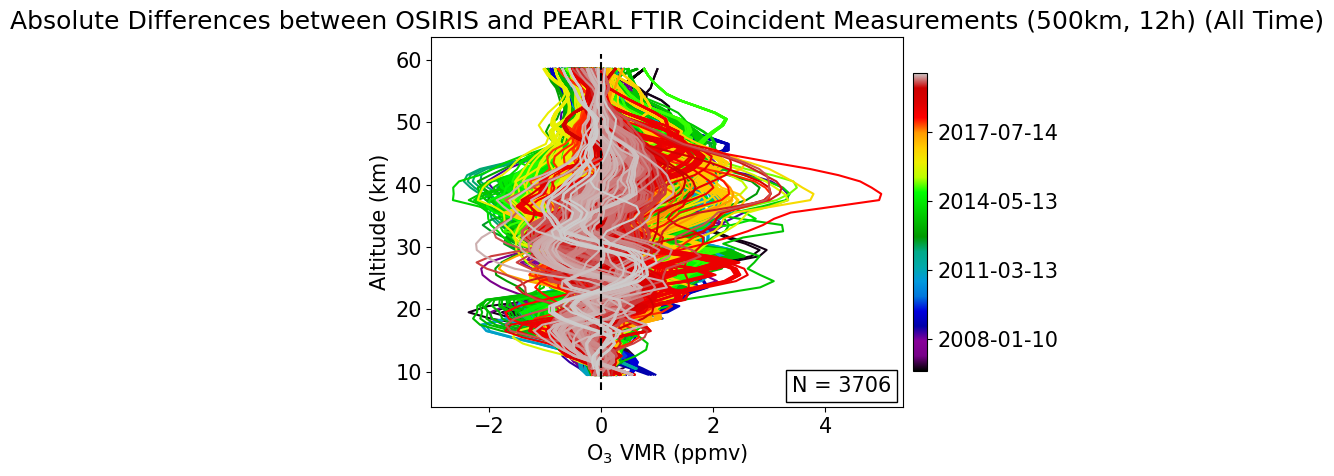

In [53]:
cmap = plt.get_cmap('nipy_spectral', n_coincidences)
measurement_colors = cmap(np.linspace(0, 1, n_coincidences))

for i in range(n_coincidences):
    plt.plot(abs[i,:] * 10**6, ALT_GRID, color = measurement_colors[i])

plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between OSIRIS and PEARL FTIR Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)")

fig = plt.gcf()
axes = plt.gca()


cbar = fig.colorbar(
    mappable,
    ax=axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.02
)

cbar.ax.set_yticklabels(cbar.get_ticks().astype('datetime64[ns]').astype('datetime64[D]').astype(str))

axes.text(0.765, 0.040, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [54]:
rel_diffs = np.nanmean(rel, axis = 0)
rel_std = np.nanstd(rel, axis = 0)
rel_err = rel_std / (rel.shape[0] ** 0.5)

abs_diffs = np.nanmean(abs, axis = 0)
abs_std = np.nanstd(abs, axis = 0)
abs_err = np.nanstd(abs, axis = 0) / (abs.shape[0] ** 0.5)

C:\Users\salla\AppData\Local\Temp\ipykernel_14156\1016612721.py:1: RuntimeWarning: Mean of empty slice
  rel_diffs = np.nanmean(rel, axis = 0)
c:\Users\salla\anaconda3\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\salla\AppData\Local\Temp\ipykernel_14156\1016612721.py:5: RuntimeWarning: Mean of empty slice
  abs_diffs = np.nanmean(abs, axis = 0)


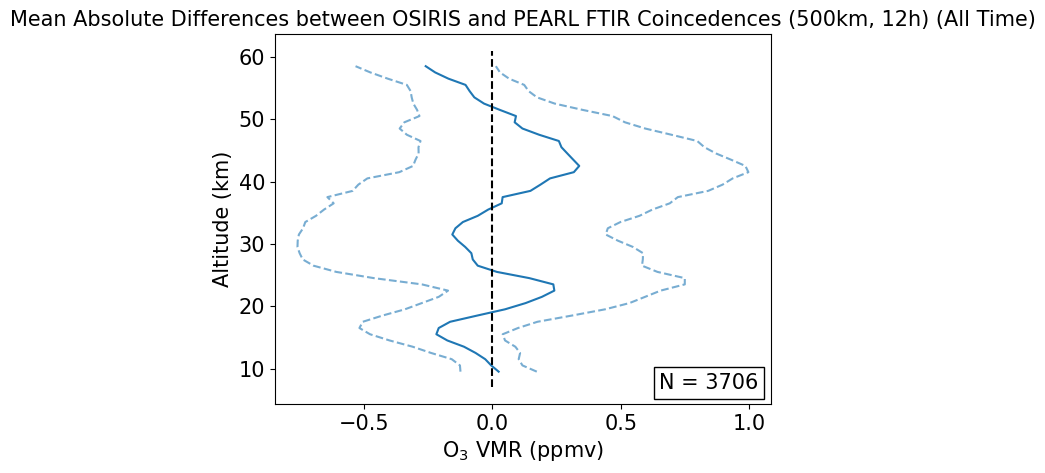

In [55]:
plt.plot(abs_diffs * 10**6, ALT_GRID)
plt.plot((abs_diffs * 10**6) + (abs_std * 10**6), ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)
plt.plot((abs_diffs * 10**6) - (abs_std * 10**6), ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean Absolute Differences between OSIRIS and PEARL FTIR Coincedences" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

axes.text(0.775, 0.040, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

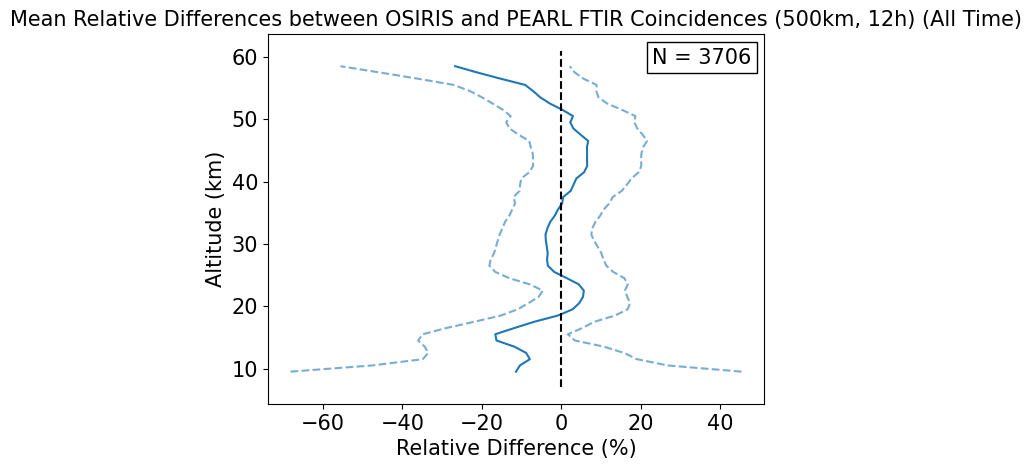

In [56]:
plt.plot(rel_diffs, ALT_GRID)
plt.plot(rel_diffs - rel_std, ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)
plt.plot(rel_diffs + rel_std, ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)
plt.plot([0, 0], list(plt.ylim()), color = "black", linestyle = "--")
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Mean Relative Differences between OSIRIS and PEARL FTIR Coincidences" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

axes.text(0.775, 0.920, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

C:\Users\salla\AppData\Local\Temp\ipykernel_14156\570604353.py:3: RuntimeWarning: Mean of empty slice
  mean_O = np.nanmean(o3O_coincidences, axis = 0)
C:\Users\salla\AppData\Local\Temp\ipykernel_14156\570604353.py:4: RuntimeWarning: Mean of empty slice
  mean_P = np.nanmean(o3P_coincidences, axis = 0)


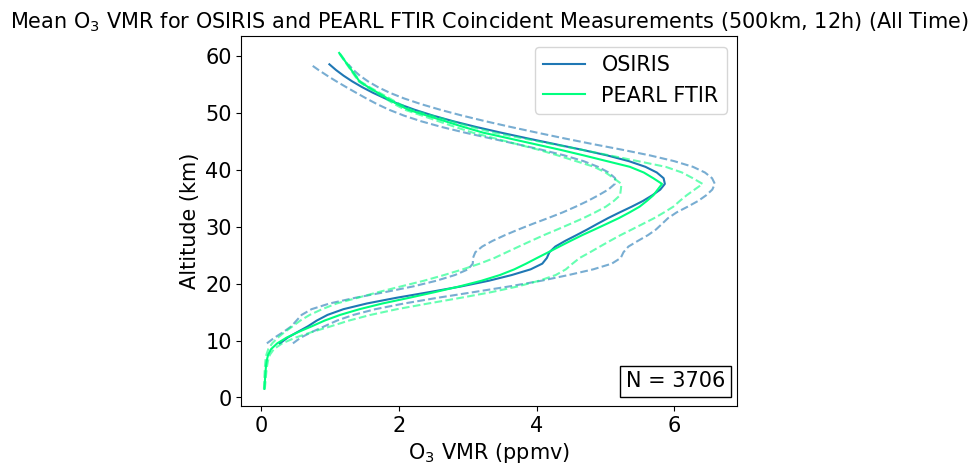

In [57]:
std_O = np.nanstd(o3O_coincidences, axis = 0)
std_P = np.nanstd(o3P_coincidences, axis = 0)
mean_O = np.nanmean(o3O_coincidences, axis = 0)
mean_P = np.nanmean(o3P_coincidences, axis = 0)

plt.plot(mean_O * 10**6, ALT_GRID, label = "OSIRIS")
plt.plot((mean_O - std_O) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)
plt.plot((mean_O + std_O) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed", alpha = 0.6)


plt.plot(mean_P * 10**6, ALT_GRID, label = "PEARL FTIR", color = "springgreen")
plt.plot((mean_P - std_P) * 10**6, ALT_GRID, color = "springgreen", linestyle = "dashed", alpha = 0.6)
plt.plot((mean_P + std_P) * 10**6, ALT_GRID, color = "springgreen", linestyle = "dashed", alpha = 0.6)

plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean O$_3$ VMR for OSIRIS and PEARL FTIR Coincident Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", fontdict = {'fontsize': 15})
plt.legend()

fig = plt.gcf()
axes = plt.gca()

axes.text(0.775, 0.050, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title + "(OSIRIS and PEARL FTIR)", bbox_inches="tight")

In [58]:
o3O_std = np.nanstd(o3O_coincidences, axis = 0)[None, :]
o3P_std = np.nanstd(o3P_coincidences, axis = 0)[None, :]
o3O_mean = np.nanmean(o3O_coincidences, axis = 0)[None, :]
o3P_mean = np.nanmean(o3P_coincidences, axis = 0)[None, :]

C:\Users\salla\AppData\Local\Temp\ipykernel_14156\3100681542.py:3: RuntimeWarning: Mean of empty slice
  o3O_mean = np.nanmean(o3O_coincidences, axis = 0)[None, :]
C:\Users\salla\AppData\Local\Temp\ipykernel_14156\3100681542.py:4: RuntimeWarning: Mean of empty slice
  o3P_mean = np.nanmean(o3P_coincidences, axis = 0)[None, :]


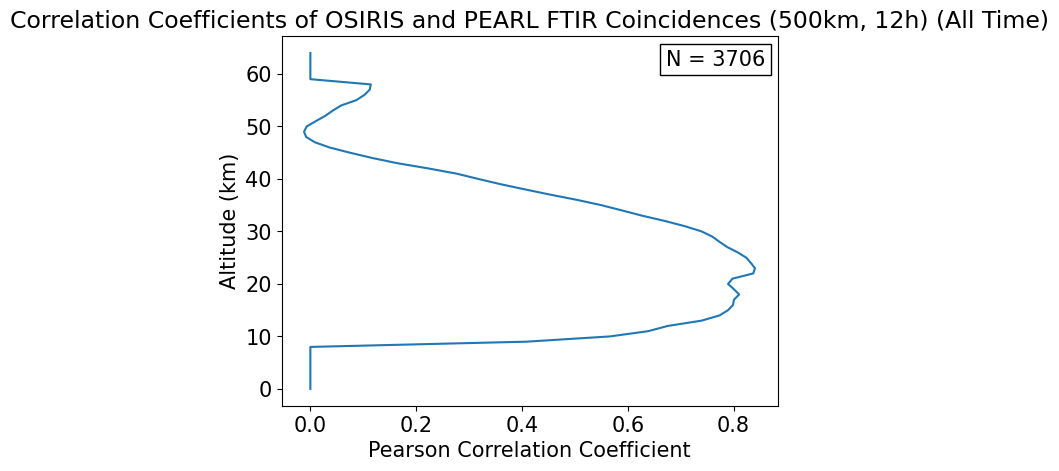

In [59]:
summing = np.nansum(((o3O_coincidences - o3O_mean) / o3O_std) * ((o3P_coincidences - o3P_mean) / o3P_std), axis = 0) 

plt.plot(summing / (o3O_coincidences.shape[0] - 1), np.arange(len(summing)))
plt.ylabel("Altitude (km)")
plt.xlabel("Pearson Correlation Coefficient")
plt.title("Correlation Coefficients of OSIRIS and PEARL FTIR Coincidences" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + " (All Time)", fontdict = {"fontsize": 17})

fig = plt.gcf()
axes = plt.gca()

axes.text(0.775, 0.920, f"N = {len(o3O_coincidences)}", fontsize=15, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [60]:
# fig = pcm_monthly.fig
# title = fig._suptitle.get_text()
# fig.savefig(title, bbox_inches="tight")

# fig = plt.gcf()
# axes = plt.gca()

# title = axes.get_title()
# fig.savefig(title, bbox_inches="tight")